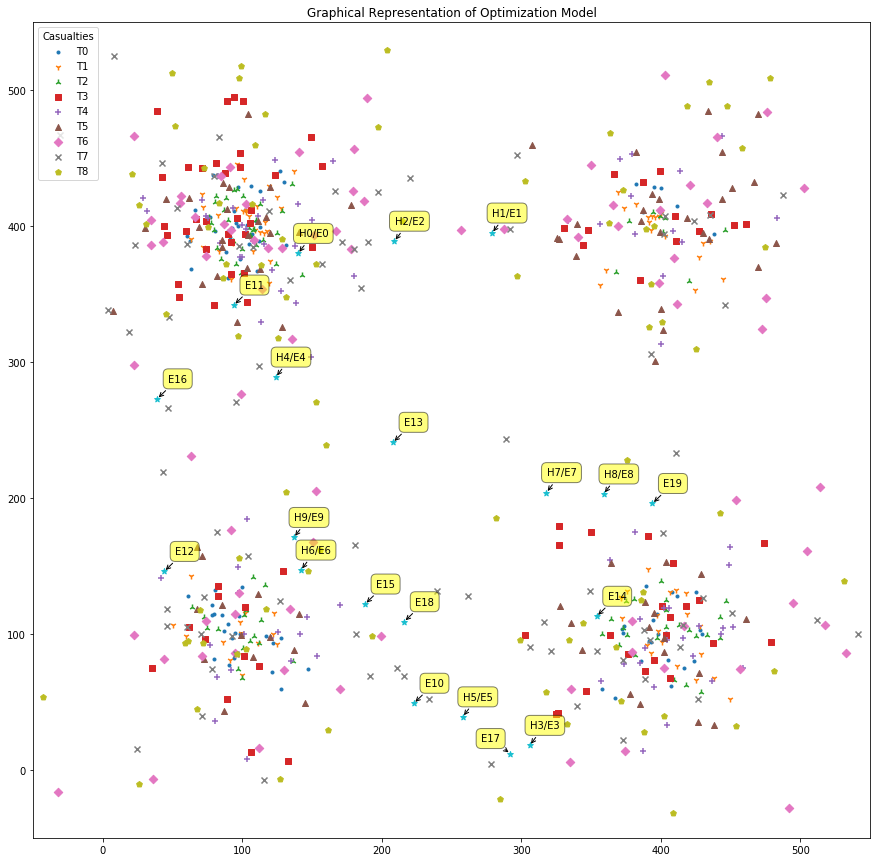

In [2]:
# TODO add relatively complete recourse!
# TODO print out solution and validate

from gurobipy import *
import numpy as np

import data_generation as Data
num_scenarios = Data.num_scenarios
num_locations = Data.num_locations
# Build Sets
T = ['T'+ str(num) for num in list(range(0,num_scenarios))]
I = ['I'+ str(num) for num in list(range(0,num_locations))]
J = ['J'+ str(num) for num in list(range(0,20))]
K = ['K'+ str(num) for num in list(range(0,10))]
L = Data.Lset
M = Data.Mset

a = Data.a_it  # injury severity (i,t)
b = Data.b_ijt  # distance injury to evac (i,j,t)
c = Data.c_ikt  # distance injury to hospital (i,k,t)
d = Data.d_jkmt  # speed (j,k,m,t)
e = Data.e_it  # total people injured (i,t)
f = Data.f_lt  # number patient bed req (l,t)
ecap = Data.ecap_mt  # m transport capacity (m,t)
hcap = Data.hcap_lt  # hospital bed type capacity (l,t)
enod = Data.enod  # evac capacity (j,t)
hnod = Data.hnod  # hospital capacity (k,t)
u = Data.u  # max num hospital sites to open
v = Data.v  # max num evac sites to open
wx = Data.wx_scen  # proportion ground evac req (t)
p = Data.p_t  # probability of each scenario

#print(T)
#print(I)
#print(J)
#print(K)
#print(L)
#print(M)
Data.plot_map()

#print(p)
#print(b)
#print(c)
#print(d)
#print(e)
#print(a)
#print(f)
#print(ecap)
#print(hcap)


# todo G set for ground vehicles
#G = None

In [15]:
c_ForAllScen = [p[t] * a[i,t] * ((b[i,j,t] + c[i,k,t]) / d[j,k,m,t])
                for i in I for j in J for k in K for l in L for m in M for t in T]

# Build model
m = Model("2SP_ExtForm")

# First stage decison variables
y = m.addVars(J, vtype=GRB.BINARY, name='y')  # select evac site
z = m.addVars(K, vtype=GRB.BINARY, name='z')  # select hospital site

# Second stage decision variables
x = m.addVars(I, J, K, L, M, T, obj=c_ForAllScen, name='x')

m.modelSense = GRB.MINIMIZE

# constraints
m.addConstrs(
    (x.sum(i, '*', '*', '*', '*', t) == e[i,t] for i in I for t in T), name='EvacAll')

m.addConstrs(
    (x.sum('*', '*', '*', '*', m, t) <= ecap[m,t] for m in M for t in T), name='CapEvac')

# check why [i][t] thought it was [l][t]        
m.addConstrs(
    (x.sum('*', '*', '*', l, '*', t) <= hcap[l,t] for l in L for t in T), name='CapHospital')

m.addConstrs(
    (x.sum('*', j, '*', '*', '*', t) <= enod * y[j] for j in J for t in T), name='CapEvacFlow')

m.addConstrs(
    (x.sum('*', '*', k, '*', '*', t) <= hnod * z[k] for k in K for t in T), name='CapHospitalFlow')

###m.addConstr((quicksum(y(j) for j in J) == v),name = 'CapEvacSites')

m.addConstr((y.sum('*') == v), name='CapEvacSites')

m.addConstr((z.sum('*') == u), name='CapHospitalSites')


m.addConstrs((x.sum('*', '*', '*', '*', 'G', t) >= (wx[t] * x.sum('*','*','*','*','*',t)) for t in T), name='GroundTransportProportion')
                                               
m.addConstrs((x.sum('*', '*', '*', l, '*', t) == f[l,t] for l in L for t in T), name='new')


m.optimize()

OptimalValue_2SP = m.objVal
print('\nEXPECTED COST : %g' % OptimalValue_2SP)


Optimize a model with 1073 rows, 864030 columns and 6048300 nonzeros
Variable types: 864000 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [1e-02, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 45 rows and 0 columns (presolve time = 5s) ...
Presolve removed 45 rows and 0 columns
Presolve time: 5.56s
Presolved: 1028 rows, 864030 columns, 3888300 nonzeros
Variable types: 864000 continuous, 30 integer (30 binary)
Found heuristic solution: objective 475.9931855

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1829170e+02   1.942850e+03   0.000000e+00      9s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      3.1829170e+02      9s
       1        393   1.5410032e+08   3.3169270e+02      9s
       2        614   5.2300357e+07   

In [14]:
print('SOLUTION:')
for j in J:
    if y[j].x > 0.99:
        print(y[j].VarName + str(y[j].x))
for k in K:
    if z[k].x > 0.99:
        print(z[k].VarName + str(z[k].x))

SOLUTION:
y[J0]1.0
y[J1]1.0
y[J3]1.0
y[J6]1.0
y[J8]1.0
y[J11]1.0
y[J12]1.0
y[J14]1.0
y[J15]1.0
y[J19]1.0
k[K0]1.0
k[K1]1.0
k[K3]1.0
k[K6]1.0
k[K8]1.0


In [18]:
for i in I:
    for j in J:
        for k in K:
            for l in L:
                for m in M:
                    for t in T:
                        if x[i][j][k][l][m][t].x > 0.0:
                            print(x[i][j][k][l][m][t].VarName + str(x[i][j][k][l][m][t].x))

KeyError: 'I0'

KeyError: 1